# Classifier Metropolis Hastings

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Shows you how to use Metropolis Hastings MCMC for inference problems.

## Poisson

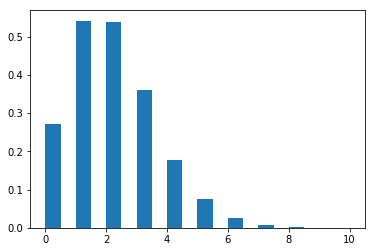

In [2]:
from cag.benchmark.poisson import allocate_observations

# Sample the (true) observations.
theta_true, x_o = allocate_observations(2.)

plt.hist(x_o.numpy(), bins=20, density=True)
plt.show()

In [3]:
from cag.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

In [4]:
from cag.transition import UniformTransitionDistribution

transition = UniformTransitionDistribution(0,5)

In [5]:
def allocate_classifier():
    hidden = 100
    return torch.nn.Sequential(
    torch.nn.Linear(1, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.PReLU(),
    torch.nn.Linear(hidden, 1),
    torch.nn.Sigmoid()
)

In [8]:
from cag.inference import LikelihoodFreeMetropolisHastings

cmh = LikelihoodFreeMetropolisHastings(simulator, allocate_classifier(), transition)

In [9]:
initializer = torch.distributions.uniform.Uniform(0, 5)

#cmh.infer(x_o, initializer, 1000)

In [10]:
from cag.util import sample

In [11]:
from cag.inference.avo import r1

## Testing

In [12]:
a = initializer.sample().view(-1)
a = torch.tensor([2.7429])
x_a = cmh._simulate(a)
b = initializer.sample().view(-1)
b = torch.tensor([4.7041])
x_b = cmh._simulate(b)

In [16]:
batch_size = 32
real = torch.ones(batch_size, 1)
fake = torch.zeros(batch_size, 1)

bce = torch.nn.BCELoss()
mse = torch.nn.MSELoss()
classifier = allocate_classifier()
optimizer = torch.optim.Adam(classifier.parameters())
for i in range(5000):
    x_real = sample(x_a, batch_size)
    #x_real.requires_grad = True
    x_fake = sample(x_b, batch_size)
    y_real = classifier(x_real)
    y_fake = classifier(x_fake)
    loss = (mse(y_real, real) + mse(y_fake, fake)) / 2.
    gradients = torch.autograd.grad(loss, classifier.parameters(), create_graph=True)
    gradient_norm = 0
    for gradient in gradients:
        gradient_norm = gradient_norm + (gradient ** 2).norm(p=1)
    gradient_norm /= len(gradients)
    loss = loss + gradient_norm
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

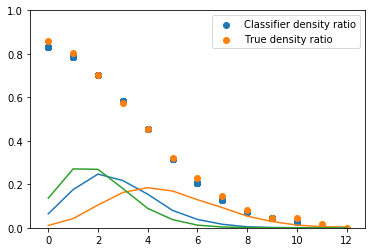

In [17]:
x = np.arange(0, 14, 1)
h_a, _ = np.histogram(x_a.numpy(), density=True, bins=x)
h_b, _ = np.histogram(x_b.numpy(), density=True, bins=x)
h_o, _ = np.histogram(x_o.numpy(), density=True, bins=x)

x_plot = np.arange(0, 13, 1)
plt.plot(x_plot, h_a)
plt.plot(x_plot, h_b)
plt.plot(x_plot, h_o)
plt.scatter(x_o.detach().numpy(), classifier(x_o).detach().numpy(), label="Classifier density ratio")
true_ratio = []
for x in x_plot:
    true_ratio.append(h_a[x] / (h_a[x] + h_b[x]))
plt.scatter(x_plot, true_ratio, label="True density ratio")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [18]:
(classifier(x_o).detach()).mean() / (1 - (classifier(x_o).detach()).mean())

tensor(2.0818)